<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_12_ConvLSTM_single_input%2C_1hr_back%2C_2hr_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
* Inputs: 12 sat readings, 128x128, Devon crop
* Outputs: single PV reading, time + 24

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pv_df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/devon_pv_readings_sun_crop_colab.pkl')
print(pv_df.columns) # This should only have 6835, 7159, 7245, 7276, 7763
pv_df = pd.DataFrame(pv_df['Mean']) # We actually only care about the mean value

Index(['6835', '7159', '7245', '7276', '7763', 'Mean', 'altitude'], dtype='object')


In [ ]:
train_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/train_sat_images_reduced.npy')
train_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/train_sat_times_reduced.npy')

test_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/test_sat_images_reduced.npy')
test_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/test_sat_times_reduced.npy')

In [ ]:
print(test_sat_images.shape)
print(test_sat_times.shape)

print(train_sat_images.shape)
print(train_sat_times.shape)


(11405, 128, 128)
(11405,)
(56434, 128, 128)
(56434,)


In [ ]:
# Now we want to make batches of images and PV readings, which will have to match up to the 

# 1. We need the blocks to be only drawn from the same day, not across different days, so we need a list of days

def get_list_of_days(list_of_timestamps):

  '''
    Takes a list of timestamps, including time
    Returns a list of unique days
  '''

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  return list(dict.fromkeys(list_of_days))


In [ ]:
# Does it work? - yes 

get_list_of_days(train_sat_times)[:5]

[datetime.date(2020, 1, 1),
 datetime.date(2020, 1, 2),
 datetime.date(2020, 1, 3),
 datetime.date(2020, 1, 4),
 datetime.date(2020, 1, 5)]

In [ ]:
# Get all the timestamps in one day

def get_blocks_of_timestamps_for_one_day(date, list_of_timestamps):

  timestamps_in_day = []

  for i in list_of_timestamps:
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  # How many blocks of three hours are there in each day?

  blocks_in_day = (len(timestamps_in_day) // (12 * 3)) 

  block_list = []

  for i in range(blocks_in_day):
    block = timestamps_in_day[(i*12*3):(i+1)*12*3] # We make a slice from the timestamps_in_day list
    block_list.append(block)

  return np.asarray(block_list)


In [ ]:
def get_full_block_list(list_of_timestamps):

  list_of_days = get_list_of_days(list_of_timestamps)

  full_block_list = []

  for day in list_of_days:
    block_list_for_day = get_blocks_of_timestamps_for_one_day(day, list_of_timestamps)
    
    if block_list_for_day.shape[0] != 0: # some days there are no PV readings, exclude those
      full_block_list.append(block_list_for_day)

  full_block_list = np.concatenate(full_block_list)

  return full_block_list

In [ ]:
def pv_readings_for_sat_times(selected_sat_times, pv_readings_series):

  pv_readings_for_sat_times = []

  for time in selected_sat_times:
    try:
      reading = pv_readings_series[pv_readings_series.index == time][0]
      pv_readings_for_sat_times.append(reading)
    except IndexError:
      pv_readings_for_sat_times.append(0)
  
  pv_readings_for_sat_times = np.asarray(pv_readings_for_sat_times, dtype=object).astype('float32')

  np.nan_to_num(pv_readings_for_sat_times, copy=False)

  return pv_readings_for_sat_times

In [ ]:
def get_sat_and_pv_blocks(full_block_list, sat_times_list, sat_images_list, pv_list):

  length = full_block_list.shape[0]

  sat_images_array = np.zeros(shape=(length, 12, 128, 128))
  pv_targets_array = np.zeros(shape=(length, 24))

  for i in range(full_block_list.shape[0]):
    for j in range(full_block_list.shape[1]):

      # For the first 12 values, get the satellite images, which we find using the index

      if j < 12:
        timestamp = full_block_list[i,j]
        index = np.where(sat_times_list == timestamp)[0][0]
        #print(j, index)
        sat_images_array[i,j] = sat_images_list[index]

      # If j is larger than 12, then get the pv readings, again using the index
      else:
        timestamp = full_block_list[i,j]
        index = np.where(sat_times_list == timestamp)[0][0]
        pv_targets_array[i,(j-12)] = pv_list[index]
        #print(j, index)
  print('Satellite and PV blocks generated. \nSat images array:', sat_images_array.shape, '\nPV targets array:', pv_targets_array.shape)
  
  return sat_images_array, pv_targets_array

In [ ]:
# get_full_block_list(list_of_timestamps)
# - get_blocks_of_timestamps_for_one_day 
# - get_list_of_days

train_blocks = get_full_block_list(train_sat_times)
test_blocks = get_full_block_list(test_sat_times)
print(train_blocks.shape)
print(test_blocks.shape)

# pv_readings_for_sat_times(selected_sat_times, pv_readings_series)

train_pv = pv_readings_for_sat_times(train_sat_times, pv_df.iloc[:,-1])
test_pv = pv_readings_for_sat_times(test_sat_times, pv_df.iloc[:,-1])
print(train_pv.shape)
print(test_pv.shape)

# get_sat_and_pv_blocks

train_sat_images, train_pv_targets = get_sat_and_pv_blocks(train_blocks, sat_times_list=train_sat_times, sat_images_list=train_sat_images, pv_list=train_pv)
test_sat_images, test_pv_targets = get_sat_and_pv_blocks(test_blocks, sat_times_list=test_sat_times, sat_images_list=test_sat_images, pv_list=test_pv)


(1378, 36)
(275, 36)
(56434,)
(11405,)
Satellite and PV blocks generated. 
Sat images array: (1378, 12, 128, 128) 
PV targets array: (1378, 24)
Satellite and PV blocks generated. 
Sat images array: (275, 12, 128, 128) 
PV targets array: (275, 24)


In [ ]:

# Standardise the images

combined_sat = np.append(test_sat_images, train_sat_images)
sat_mean = combined_sat.mean()
sat_std = combined_sat.std()

test_sat_images = np.subtract(test_sat_images, sat_mean)
train_sat_images = np.subtract(train_sat_images, sat_mean)

# Standardise the PV targets

combined_pv = np.append(test_pv_targets, train_pv_targets)

pv_mean = combined_pv.mean()
pv_std = combined_pv.std()

train_pv_targets -= pv_mean
test_pv_targets -= pv_mean

train_pv_targets /= pv_std
test_pv_targets /= pv_std



In [ ]:
from sklearn import utils

x_train, y_train = utils.shuffle(train_sat_images,  train_pv_targets)
x_test, y_test = utils.shuffle(test_sat_images, test_pv_targets)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

inp = layers.Input(shape=(x_train.shape[1:]))

dropout_rate = 0.3

x = layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True, activation="relu")(inp)
x = layers.MaxPooling3D(pool_size=(1,2,2))(x)

x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True) (x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)


x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True) (x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)

x = layers.ConvLSTM2D(filters=32, kernel_size=(3,3), dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=False, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)

# OCF have four dense layers, size seems to be something like 8 * 3 * 3, then 
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

x = layers.Dense(24, activation='linear')(x) 


model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.Adam(),
)


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Training hyperparameters
epochs = 20
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test), 
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
276/276 [==============================] - 169s 390ms/step - loss: 0.8614 - val_loss: 0.9976 - lr: 0.0010
Epoch 2/20
276/276 [==============================] - 107s 387ms/step - loss: 0.7131 - val_loss: 0.7347 - lr: 0.0010
Epoch 3/20
276/276 [==============================] - 107s 387ms/step - loss: 0.6621 - val_loss: 0.6148 - lr: 0.0010
Epoch 4/20
276/276 [==============================] - 106s 386ms/step - loss: 0.5990 - val_loss: 0.7070 - lr: 0.0010
Epoch 5/20
276/276 [==============================] - 106s 386ms/step - loss: 0.5790 - val_loss: 0.9400 - lr: 0.0010
Epoch 6/20
276/276 [==============================] - 106s 384ms/step - loss: 0.5489 - val_loss: 0.7320 - lr: 0.0010
Epoch 7/20
276/276 [==============================] - 106s 384ms/step - loss: 0.5022 - val_loss: 0.5307 - lr: 0.0010
Epoch 8/20
276/276 [==============================] - 106s 383ms/step - loss: 0.4936 - val_loss: 0.6342 - lr: 0.0010
Epoch 9/20
276/276 [==============================] - 106s 383ms

In [ ]:
# How does this compare to truth?

test_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/test_sat_images_reduced.npy')
test_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 12/test_sat_times_reduced.npy')

test_sat_images = np.expand_dims(test_sat_images, axis=-1)

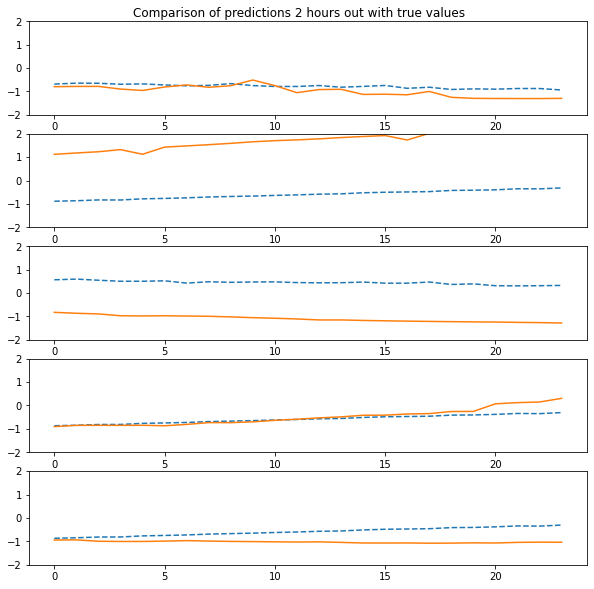

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(5):

  plt.subplot(5,1,i+1)

  predictions = np.squeeze(model.predict(np.expand_dims(x_test[i], axis=0)))

  plt.plot(np.arange(len(predictions)), predictions, '--')
  plt.plot(np.arange(len(y_test[i])), y_test[i])
  plt.ylim([-2,2])

plt.suptitle('Comparison of predictions 2 hours out with true values', y=0.9);